In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

plt.style.use('ggplot')
import plotly.express as px

sns.set(rc ={'figure.figsize': (12,6)}, style = "whitegrid")

In [3]:
data = pd.read_csv('hw_bootstrap.csv', sep=';')
data.shape

(1000, 3)

### Описание колонок

value – значения метрики
experimentVariant – Вариант теста (Control – контроль, Treatment – тест)

### Задача

Нужно понять, стали ли мы больше зарабатывать с пользователя или нет. Вы уже знаете о существовании t-теста, U-теста Mann-Whitney и бутстрапа. Открытый вопрос: какой инструмент использовать?

1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних
2. Сравните результат между тестом и контролем по всем этим кейсам
3. Напишите выводы, которые можно сделать на основе анализа примененных критериев. 
Напишите, почему мы должны использовать тот или иной инструмент: 
каких предположений о случайной величине нужно придерживаться, какие условия необходимы и т.п.

In [5]:
data.dtypes

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

In [6]:
# так как данные некорректно отображались, исправил методом replace() and astype()
data['value'] = data['value'].apply(lambda x: x.replace(',', '.')).astype({'value': 'float'})

In [7]:
data.head()

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control


In [8]:
# Проверил как распределены группы
data.groupby(['experimentVariant']).size()

experimentVariant
Control      500
Treatment    500
dtype: int64

In [10]:
# Заметно, что с вариантом Treatment что-то не так
data.groupby('experimentVariant').value.std()

experimentVariant
Control        0.979377
Treatment    186.557011
Name: value, dtype: float64

In [30]:
# Есть серьезные значения, которые завышают показания в количестве 5 шт. 
# Как видно, что это последние 5 элементов
data.value.sort_values(ascending=False).head(7)

999    3000.000000
998    2000.000000
997    1500.000000
996    1200.000000
995    1000.000000
671      13.130346
171      13.130346
Name: value, dtype: float64

In [12]:
# Попробовал применить log(), но как видно на графике ниже - не сильно помогло
data['value_log'] = np.log(data.value)

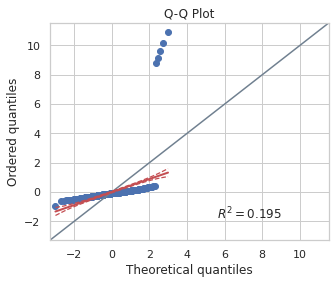

In [13]:
# По qqplot видны эти самые 5 выбросов. Решил избавиться от этих значений,
# т.к. вероятнее всего это ошибка и понизит шанс допустить ошибку первого рода
pg.qqplot(data.query("experimentVariant == 'Treatment'").value_log)

In [14]:
data_fix = data.query("value < 50")
data_fix.shape

(995, 4)

In [15]:
data_fix.head()

,Unnamed: 0,value,experimentVariant,value_log
0,1,10.380495,Control,2.339929
1,2,9.546867,Control,2.256213
2,3,11.088215,Control,2.405883
3,4,10.147274,Control,2.317205
4,5,9.789808,Control,2.281342


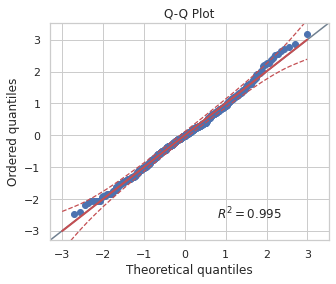

In [16]:
# Теперь с данными можно работать
pg.qqplot(data_fix.query("experimentVariant == 'Treatment'").value)

In [17]:
# Проверю на нормальность распределения
pg.normality(data=data_fix, dv='value', group='experimentVariant')

,W,pval,normal
Control,0.995925,0.224164,True
Treatment,0.995552,0.171882,True


In [18]:
# Шапиро
pg.normality(data=data_fix, dv='value', group='experimentVariant')

,W,pval,normal
Control,0.995925,0.224164,True
Treatment,0.995552,0.171882,True


In [19]:
# Зашел по альтернативному тесту
pg.normality(data=data_fix, dv='value', group='experimentVariant', method='normaltest')

,W,pval,normal
Control,2.943459,0.229528,True
Treatment,3.426451,0.180283,True


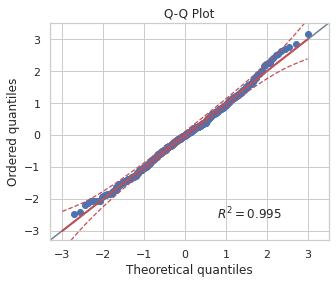

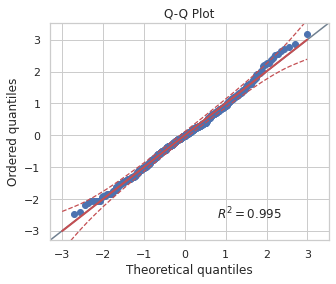

In [20]:
# Построил qqplot для двух групп, видно что они равны
pg.qqplot(data_fix.query("experimentVariant == 'Control'").value)
pg.qqplot(data_fix.query("experimentVariant == 'Treatment'").value)

#### Пробую t-test

In [21]:
# scipy
ss.ttest_ind(a=data_fix.query("experimentVariant == 'Treatment'").value,
             b=data_fix.query("experimentVariant == 'Control'").value)

Ttest_indResult(statistic=-0.08299135107595523, pvalue=0.9338751428058142)

In [22]:
# pg
pg.ttest(x=data_fix.query("experimentVariant == 'Treatment'").value,
         y=data_fix.query("experimentVariant == 'Control'").value)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.082992,992.92318,two-sided,0.933875,"[-0.13, 0.12]",0.005262,0.071,0.050788


#### Пробую Манна-Уитни

In [25]:
# По U-критерию Манна-Уитни (более устойчивому к выбросам), видно, что различий нет
ss.mannwhitneyu(x=data_fix.query("experimentVariant == 'Treatment'").value,
                y=data_fix.query("experimentVariant == 'Control'").value)

MannwhitneyuResult(statistic=123310.5, pvalue=0.9228386264147465)

In [26]:
# Взял t-test, применил его к исходной data
ss.ttest_ind(a=data.query("experimentVariant == 'Treatment'").value,
             b=data.query("experimentVariant == 'Control'").value, trim=0.2)

Ttest_indResult(statistic=0.11365837448856046, pvalue=0.9095467577361408)

#### Bootstrap

In [27]:
data_fix.head()

,Unnamed: 0,value,experimentVariant,value_log
0,1,10.380495,Control,2.339929
1,2,9.546867,Control,2.256213
2,3,11.088215,Control,2.405883
3,4,10.147274,Control,2.317205
4,5,9.789808,Control,2.281342


##### Подготовлю данные

In [28]:
data_Treatment = data_fix.query("experimentVariant == 'Treatment'").value.to_frame()
data_Treatment.shape

(495, 1)

In [29]:
data_control = data_fix.query("experimentVariant == 'Control'").value.to_frame()
data_control.shape

(500, 1)

In [33]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def get_bootstrap(
    data_Treatment, # числовые значения первой выборки (Column_1)
    data_control, # числовые значения второй выборки (Column_2)
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_Treatment), len(data_control)])
    boot_data = []
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = data_Treatment.sample(boot_len,replace=True).values
        samples_2 = data_control.sample(boot_len,replace=True).values
        
        boot_data.append(statistic(samples_1 - samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
    
    return {"p-value": p_value}

In [40]:
# Применяю сравнения по заданию. Бутстрап (с np.mean) и критерий Манна-Уитни, а потом сравнение p-value

x = data['value'][(data['experimentVariant'] == 'Control')]
y = data['value'][(data['experimentVariant'] == 'Treatment')]

res_mw = mannwhitneyu(x, y, alternative = 'two-sided')
for i in range(10):
    res_b_npmean = get_bootstrap(x, y)
    res_b_npmedian = get_bootstrap(x, y, statistic = np.median)
    
    print(f'Boot mean: {res_b_npmean}, Boot median: {res_b_npmedian}, MW {res_mw.pvalue}')

Boot mean: {'p-value': 0.03670752735517858}, Boot median: {'p-value': 0.8558538749420135}, MW 0.8592148582485579
Boot mean: {'p-value': 0.04312525458000907}, Boot median: {'p-value': 0.8549006856306683}, MW 0.8592148582485579
Boot mean: {'p-value': 0.042980534160086174}, Boot median: {'p-value': 0.899766134886815}, MW 0.8592148582485579
Boot mean: {'p-value': 0.03846345934672902}, Boot median: {'p-value': 0.8440615377454683}, MW 0.8592148582485579
Boot mean: {'p-value': 0.03780878345371973}, Boot median: {'p-value': 0.9274704826356812}, MW 0.8592148582485579
Boot mean: {'p-value': 0.034082905941686614}, Boot median: {'p-value': 0.9468530576160494}, MW 0.8592148582485579
Boot mean: {'p-value': 0.04332851483280266}, Boot median: {'p-value': 0.8565213910441418}, MW 0.8592148582485579
Boot mean: {'p-value': 0.04274958574299458}, Boot median: {'p-value': 0.8634209925650214}, MW 0.8592148582485579
Boot mean: {'p-value': 0.031646321011348774}, Boot median: {'p-value': 0.890845503328858}, MW 0

## Выводы

1. Сравнивая средние по бутстрапу p-value всегда на границе 0,03 - 0,04. Это говорит о том, что можно отклонять Но-гипотезу;
2. По медиане бутстрап показывает очень схожий результат с M-W. Помним, что M-W переводит все данные в ранговую шкалу, по сути проверяем какой-то квантиль в этих рангах;
3. Бутстрап учитывает дисбаланс выборок и 'нормирует' размер выборок по верхней границе;
4. Бутстрап является более релевантным оценщиком, т.к. сохраняется дисперсия из ориг выборке, M-W эта дисперсия никак не учитывается.